In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

## Understanding parameter space. 

I want to know if there is generaly a global minimum for the parameters. So you should plot the space.

1) Load the data.
2) take a random sample from it
4) for a range of parameters plot the quantile loss. 

In [2]:
stock_data = ACP_data.stock_data(1)
stock_data = ACP_data.xvy_from_ACP(stock_data, 10)[0]

In [8]:
### Creating the winkler loss. 

def winkler_loss_component(a, b, theta, alpha):
    if a< theta and theta < b:
        return b-a
    elif a >= theta:
        return (b-a) + (2/alpha)*(a-theta)
    else:
        return (b-a) + (2/alpha)*(theta-b)

def all_winkler_loss(params, target, dataset):
    # for given constants need to calculate the implied prediction intervals and then calculate the loss. 
    # Do for one sided HACI.
    zipped_data_set = zip(dataset[0], dataset[1]) 
    
    total_loss = 0
    for i, (var, y) in enumerate(zipped_data_set):
        bound_t = params[0] + params[1] * var
        total_loss+=winkler_loss_component(-bound_t, bound_t, y, target)

    return total_loss


In [9]:
print(len(stock_data[0]))

2515


In [37]:
stock_slice = slice(500, 900)
target = 0.1

All_scores = stock_data[2] - stock_data[0]

In [38]:
def calculate_loss(phi, beta):
    return all_winkler_loss([phi, beta], target, (stock_data[1][stock_slice], All_scores[stock_slice]))


In [39]:
from mpl_toolkits.mplot3d import Axes3D

# Define the range of parameters
phi_range = np.linspace(0, 5, 100)
beta_range = np.linspace(-10, 10, 100)

# Create a meshgrid of phi and beta values
phi, beta = np.meshgrid(phi_range, beta_range)

# Calculate the loss for each combination of phi and beta
loss = np.array([[calculate_loss(phi_val, beta_val) for phi_val in phi_range] for beta_val in beta_range])

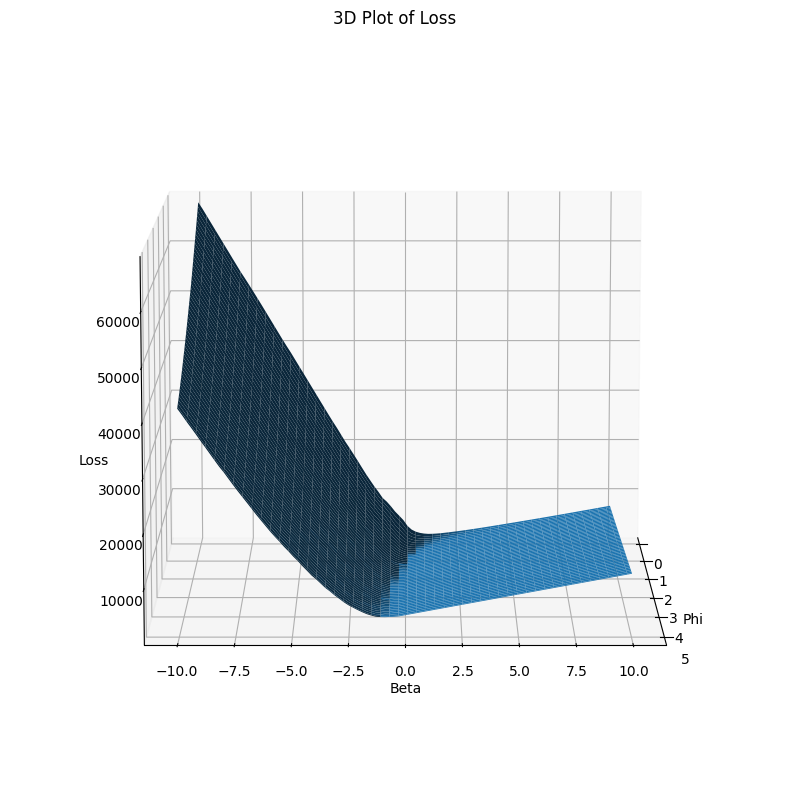

In [40]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(phi, beta, loss)

# Set labels and title
ax.set_xlabel('Phi')
ax.set_ylabel('Beta')
ax.set_zlabel('Loss')
ax.set_title('3D Plot of Loss')
ax.view_init(10, 0)

# Show the plot
plt.show()

In [41]:
calculate_loss(1, 1)

1754.339512019258

In [42]:
calculate_loss(1, -1)

4628.979238015371

In [43]:
calculate_loss(2, -1)

2981.2485839641863

In [44]:

stock_data = ACP_data.xvy_from_ACP([stock_data], 10)[0]
print(len(stock_data[0]))
stock_slice = slice(500, 1500)
target = 0.1
def calculate_loss(phi, beta):
    return AdaptiveCP.conditional_quantile_loss(None, [phi, beta], target, (stock_data[1][stock_slice], stock_data[2][stock_slice]))

cv = np.vectorize(calculate_loss)
from mpl_toolkits.mplot3d import Axes3D

# Define the range of parameters
phi_range = np.linspace(0, 5, 100)
beta_range = np.linspace(-5, 5, 100)

# Create a meshgrid of phi and beta values
phi, beta = np.meshgrid(phi_range, beta_range)

# Calculate the loss for each combination of phi and beta
loss = np.array([[calculate_loss(phi_val, beta_val) for phi_val in phi_range] for beta_val in beta_range])
# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(phi, beta, loss)

# Set labels and title
ax.set_xlabel('Phi')
ax.set_ylabel('Beta')
ax.set_zlabel('Loss')
ax.set_title('3D Plot of Loss')
ax.view_init(90, 0)

# Show the plot
plt.show()
calculate_loss(1, 1)
calculate_loss(1, -1)
calculate_loss(2, -1)

ValueError: too many values to unpack (expected 2)

## I want to know now what the loss function looks like if you are trying to minimise for the loss with the previous alphat's.

1) Load Results
2) Get the alpha_t upper dict. 
3) Rewrite the loss functions. 
4) plot.

In [ ]:
import pickle
with open(r'C:\Users\chris\Documents\Conformal_Prediction\notebooks\improvments\vol_window_raw_results1.pkl', 'rb') as file:
    simple_raw_data = pickle.load(file)



In [ ]:
acp = AdaptiveCP(0.1)
one_side_result = acp.HACI_one_side(stock_data, 0.05)

In [ ]:
alpha_t_list = one_side_result['alpha_t_list']
print(len(alpha_t_list), len(stock_data[1]))

# Cant do on dual tail easily as you dont have the alphas at each time step, should fix in 

2465 2515


In [ ]:
start, end = 250, 600

alpha_slice = slice(start, end)
stock_slice = slice(start+150, end+150)


All_scores = stock_data[2] - stock_data[0]

def calculate_loss(phi, beta):
    return conditional_quantile_loss([phi, beta], alpha_t_list[alpha_slice], (stock_data[1][stock_slice], All_scores[stock_slice]))

def pinball_loss_function(target, y, y_hat):
    'Simple pinball loss without sub'
    return (target * (y - y_hat)) - min(0, (y - y_hat))

def conditional_quantile_loss(params: list, target_alpha, dataset: list[tuple]):
    ''' Calculates the loss if we were to use the lambda_const and lambda_var provided.'''
    zipped_data_set = zip(target_alpha, dataset[0], dataset[1]) 
    loss_list = [AdaptiveCP.pinball_loss_function(target_alpha, y, (params[0] + params[1] * var)) for target_alpha, var, y in zipped_data_set]

    return sum(loss_list)

cv = np.vectorize(calculate_loss)
from mpl_toolkits.mplot3d import Axes3D

# Define the range of parameters
phi_range = np.linspace(-5, 5, 100)
beta_range = np.linspace(-10, 10, 100)

# Create a meshgrid of phi and beta values
phi, beta = np.meshgrid(phi_range, beta_range)

# Calculate the loss for each combination of phi and beta
loss = np.array([[calculate_loss(phi_val, beta_val) for phi_val in phi_range] for beta_val in beta_range])

lower_bound, upper_bound = [(None, 0), (None, None)], [(0, None), (None, None)]

from scipy.optimize import minimize
lower_params = minimize(conditional_quantile_loss, (0, 0), 
                                    bounds=lower_bound, args=(alpha_t_list[alpha_slice], (stock_data[1][stock_slice], All_scores[stock_slice]))).x
print(lower_params)

[-0.73956231  0.09854832]


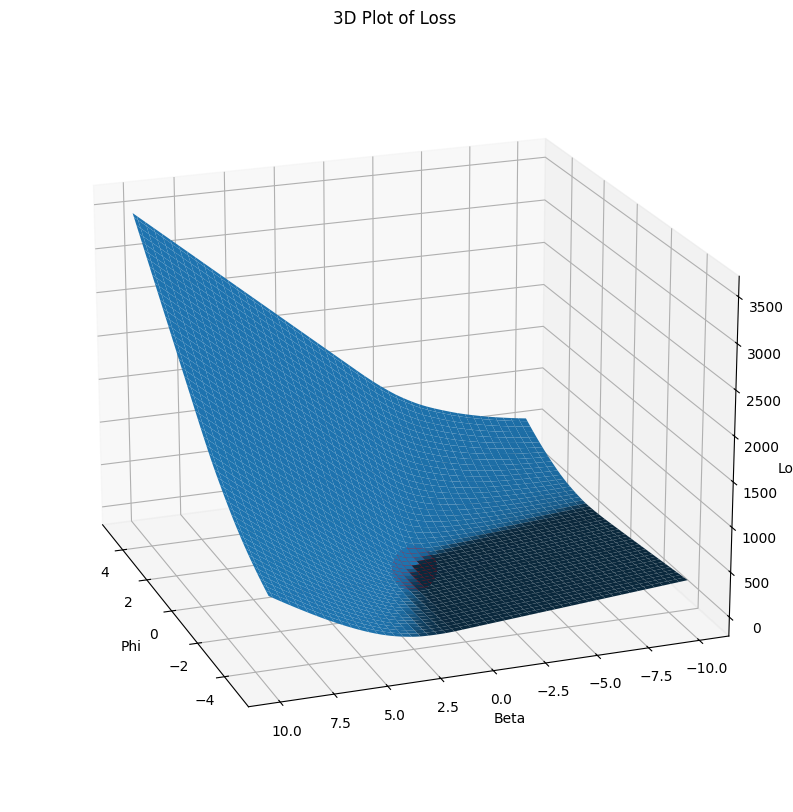

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(phi, beta, loss)

ax.scatter(lower_params[0], lower_params[1], calculate_loss(lower_params[0], lower_params[1]), color='red', s=1000)

# Set labels and title
ax.set_xlabel('Phi')
ax.set_ylabel('Beta')
ax.set_zlabel('Loss')
ax.set_title('3D Plot of Loss')
ax.view_init(20, 160)

# Show the plot
plt.show()

In [ ]:
# What is the average difference between a constant one and a non constant one. 

loss = np.array([[calculate_loss(phi_val, beta_val) for phi_val in phi_range] for beta_val in beta_range])
prev_loss = np.array([[AdaptiveCP.conditional_quantile_loss(acp, [phi_val, beta_val], 0.1, (stock_data[1][stock_slice], All_scores[stock_slice])) for phi_val in phi_range] for beta_val in beta_range])



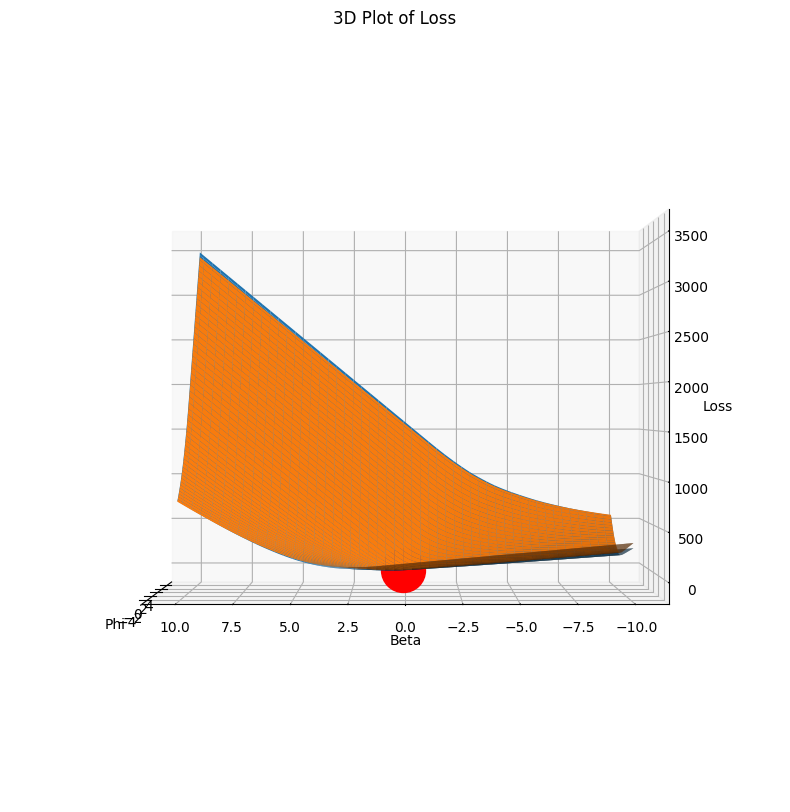

In [ ]:
diff = loss - prev_loss

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(phi, beta, diff)
ax.plot_surface(phi, beta, loss)
ax.plot_surface(phi, beta, prev_loss)

ax.scatter(lower_params[0], lower_params[1], calculate_loss(lower_params[0], lower_params[1]), color='red', s=1000)

# Set labels and title
ax.set_xlabel('Phi')
ax.set_ylabel('Beta')
ax.set_zlabel('Loss')
ax.set_title('3D Plot of Loss')
ax.view_init(0, 180)

# Show the plot
plt.show()